## Fully connected + Convolutional neuronal network

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
WORKING_PATH = '/content/drive/MyDrive/KeepCoding/DeepLearning/exercise'
OUTPUTDIR = '5_EL2_dualbranch'
NAMESTUDY = 'el2_db'

In [ ]:
%cd {WORKING_PATH}

/content/drive/MyDrive/KeepCoding/DeepLearning/exercise


In [ ]:
!pip install optuna
#!pip install -r requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.5 MB/s eta 0:00:00


In [ ]:
import sys
import pandas as pd
import numpy as np
import matplotlib as plt
import os
import torch
from torch.utils.data import Dataset, TensorDataset
from torchvision import transforms
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from sklearn.preprocessing import MultiLabelBinarizer, MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import optuna
import pickle
import cv2

In [ ]:
# to load custom libraries
sys.path.append(WORKING_PATH)

# load custom library
from utilsDualBranchNN import *

# load dataset
poi_data = pd.read_csv(os.path.join(WORKING_PATH, "poi_dataset.csv"))

set_random_seed()

In [ ]:
# split into train, val and test datasets
df_train, df_test = train_test_split(poi_data, test_size = 0.2, random_state = 16)
df_train, df_val = train_test_split(df_train, test_size = 0.2, random_state = 16)
print(f'Number of samples.')
print(f'Train dataset: {df_train.shape[0]}')
print(f'Validation dataset: {df_val.shape[0]}')
print(f'Test dataset: {df_test.shape[0]}')

Number of samples.
Train dataset: 1004
Validation dataset: 251
Test dataset: 314


In [ ]:
# calculate engagement score
df_engagement = df_train[['Visits','Bookmarks','Likes','Dislikes']].copy()
df_engagement['Likes_Dislikes'] = df_engagement['Likes'] - df_engagement['Dislikes']
df_engagement = df_engagement.drop(['Likes','Dislikes'], axis=1)
scaler_engagement = MinMaxScaler().fit(df_engagement)

# Calculate scores
def categorize_score(x):
  if x < 0.30:
    return 0
  else:
    return 1


In [ ]:
# Normalize xps, locationLon, locationLat, numTags
scaler_features = StandardScaler().fit(df_train[['xps','locationLon','locationLat']])

# one hot encoder for categories
onehot_encoder_categories = MultiLabelBinarizer().fit(poi_data['categories'].apply(eval))

# One hot encoder for tier
onehot_encoder_tier = OneHotEncoder(sparse_output=False).fit(pd.DataFrame(poi_data['tier']))


In [ ]:
def processdata(df):
  """
  Data processing steps before being used in the model.
  Same steps are applied to train, validation and test datasets.
  Processing include:
  - Calculate number of tags
  - One hot encoding for categories
  - Calculate engagement feature (low, medium, high)
  - Scale quantitative features
  - One hot encoding for tier
  - Remove features
  """
  df.index = range(df.shape[0])
  # Feature for number of tags
  df['NumTags'] = df['tags'].apply(eval).apply(len)
  # One hot encoder for categories
  categories_one_hot = onehot_encoder_categories.transform(df['categories'].apply(eval))
  df_categories_one_hot = pd.DataFrame(categories_one_hot, columns=onehot_encoder_categories.classes_)
  df = pd.concat([df, df_categories_one_hot], axis=1)
  # Engagement features
  df['Likes_Dislikes'] = df['Likes'] - df['Dislikes']
  df_engagement = df[['Visits','Bookmarks','Likes_Dislikes']]
  df['Score']= scaler_engagement.transform(df_engagement).sum(axis = 1)/3
  df['engagement'] = df['Score'].apply(categorize_score)
  # Scale features xps, locationLon, locationLat
  df[['xps','locationLon','locationLat']] = scaler_features.transform(df[['xps','locationLon','locationLat']])
  # One hot encoder for tier
  tier_one_hot = onehot_encoder_tier.transform(pd.DataFrame(df['tier']))
  df_tier_one_hot = pd.DataFrame(tier_one_hot, columns=onehot_encoder_tier.get_feature_names_out(['tier']))
  df = pd.concat([df, df_tier_one_hot], axis=1)
  # Remove features
  df_clean = df.drop(['tags','categories','id','name','shortDescription',
                      'Likes','Dislikes','Bookmarks','Visits','Score', 'Likes_Dislikes', 'tier'], axis = 1)
  return df_clean

In [ ]:
 df_train_proc = processdata(df_train)
 df_val_proc = processdata(df_val)
 df_test_proc = processdata(df_test)

In [ ]:
df_val_proc.head().T
#df_train_proc.shape
#df_val_proc['engagement'].value_counts()


,0,1,2,3,4
locationLon,-0.119776,-0.248107,-0.130991,-0.120394,-0.120193
locationLat,0.048656,1.743828,-0.031147,0.048605,0.049661
xps,0.689755,1.13697,1.13697,-0.204677,-0.204677
main_image_path,data_main/e9db85f0-a7e5-47d9-b5bf-c9679f9f5490...,data_main/23869080-e075-47f0-bb14-a07f6c704995...,data_main/e50c847d-8c94-4dc6-887e-88545c3082c6...,data_main/4cd73b93-660e-4b18-a47b-fb2840545c5f...,data_main/85bd9134-3625-4e75-ba77-fb8196c06626...
NumTags,13,1,4,10,10
Arquitectura,0,0,1,1,1
Ciencia,0,0,0,0,0
Cine,0,0,0,0,0
Cultura,1,1,0,0,0
Escultura,0,0,0,0,0


In [ ]:
# Dataset
class FC_CNNDataset(Dataset):
  def __init__(self, engagement, image_path, features, transform=None):
    self.engagement = torch.tensor(engagement.values)
    self.features = torch.tensor(features.values, dtype=torch.float32)
    self.image_path = image_path
    self.transform = transform

  def __len__(self):
        return len(self.engagement)

  def __getitem__(self, idx):
        image = cv2.imread(os.path.join(WORKING_PATH, self.image_path.iloc[idx]))
        if transform:
          image = transform(image)
        engagement = self.engagement[idx]
        features = self.features[idx]

        return image, features, engagement

In [ ]:
# Create dataset
transform = transforms.Compose([
    transforms.ToTensor()
])

train_dataset = FC_CNNDataset(df_train_proc['engagement'], df_train_proc['main_image_path'], df_train_proc.drop(['engagement', 'main_image_path'], axis=1))
val_dataset = FC_CNNDataset(df_val_proc['engagement'], df_val_proc['main_image_path'], df_val_proc.drop(['engagement', 'main_image_path'], axis=1))
test_dataset = FC_CNNDataset(df_test_proc['engagement'], df_test_proc['main_image_path'], df_test_proc.drop(['engagement', 'main_image_path'], axis=1))

In [ ]:
#batch_size=16
#train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#for e in train_loader:
#  print(e[0].keys())
#  print(e[0].shape)
#  print(e[0])
#  print(e[0].max())
#  print(e[0].min())
#  break

In [ ]:
# Hyperparameters
num_epochs = 6
batch_size = 128
learning_rate = 0.01
dropout_rate = 0.2

In [ ]:
# Define FCNN_CNN
class FC_CNN(nn.Module):
    def __init__(self, dropout_rate):
        super(FC_CNN, self).__init__()

        # CNN: First convolutional layer
        self.CNN_convLayer1 = nn.Sequential(
            nn.Conv2d(3, 8, 3, padding = 1),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.Dropout(dropout_rate)
        )

        # CNN: Set global pooling (max/avg)
        self.global_max_pool = nn.AdaptiveMaxPool2d(1) # torch.nn.AdaptiveMaxPool2d(output_size,...)
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1)

        # FCNN: First fully connected layer
        self.FCNN_fcLayer1 = nn.Sequential(
            nn.Linear(20, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Classificator: Fully connected layer
        self.class_fcLayer1 = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(16, 2)
        )

    def forward(self, x_cnn, x_fcnn):
        x_cnn = self.CNN_convLayer1(x_cnn)
        max_pooled = self.global_max_pool(x_cnn).squeeze()
        avg_pooled = self.global_avg_pool(x_cnn).squeeze()
        x_cnn = torch.cat((max_pooled, avg_pooled), dim=1)
        x_fcnn = self.FCNN_fcLayer1(x_fcnn)
        x = torch.cat((x_cnn, x_fcnn), dim = 1)
        x = self.class_fcLayer1(x)
        return x

Device: cpu
Epoch 1, Loss: 0.5519885383546352, Acc: 72.50996015936255, Val Loss: 0.5366056859493256, Val Acc: 75.69721115537848, LR: 0.01
Epoch 2, Loss: 0.4152556546032429, Acc: 83.76494023904382, Val Loss: 0.7818423807621002, Val Acc: 75.69721115537848, LR: 0.01
Epoch 3, Loss: 0.36587611958384514, Acc: 85.2589641434263, Val Loss: 0.8684037625789642, Val Acc: 75.69721115537848, LR: 0.01
Epoch 4, Loss: 0.35295044630765915, Acc: 88.24701195219123, Val Loss: 0.8249081075191498, Val Acc: 75.69721115537848, LR: 0.01
Epoch 5, Loss: 0.33616916090250015, Acc: 87.84860557768924, Val Loss: 0.5644617080688477, Val Acc: 75.69721115537848, LR: 0.01
Epoch 6, Loss: 0.314987001940608, Acc: 88.74501992031873, Val Loss: 0.46761655807495117, Val Acc: 79.6812749003984, LR: 0.01


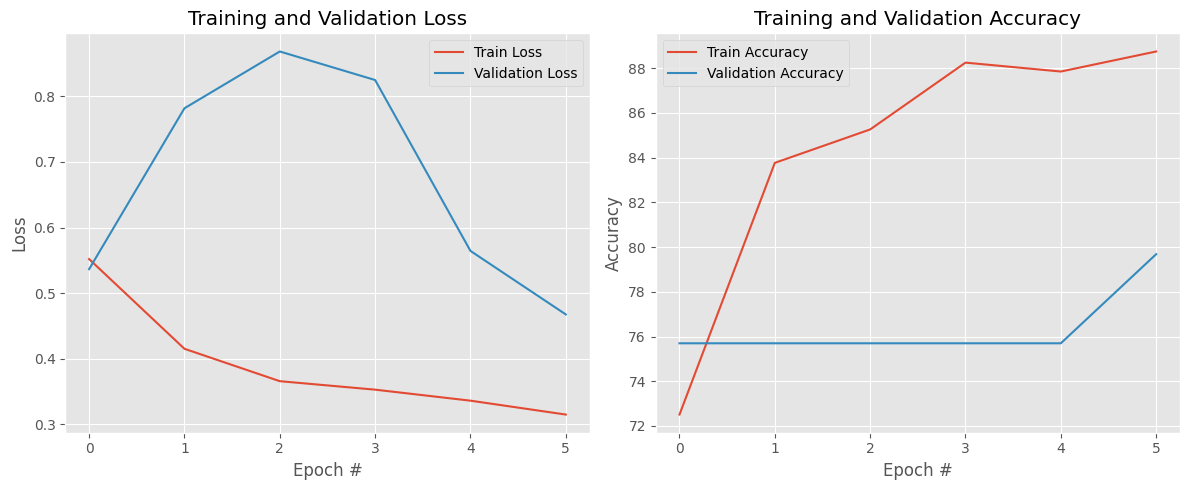

In [ ]:
# train model (check if model is ok)
set_random_seed()
model = FC_CNN(dropout_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader, device)


In [ ]:
def objective(trial):
    """
    Objective function for hyperparameter optimization with Optuna.
    """

    # seed for random numbers
    set_random_seed()

    # hyperparameters to optimize
    dropout_rate = trial.suggest_float("dropout_rate", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-3, 1e-1, log=True)

    # define dataloader
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # build model and move to device
    model = FC_CNN(dropout_rate).to(device)

    # optimizer and loss function
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()

    # init list for output values
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []

    # train model
    for epoch in range(num_epochs):
        train_loss, train_acc, _ = train_epoch(model, device, train_loader, criterion, optimizer)
        val_loss, val_acc = eval_epoch(model, device, val_loader, criterion)

        # save output from training and validation
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

    # save output to a file
    output_metrics_file = os.path.join(WORKING_PATH,OUTPUTDIR,f"metrics_{trial.number}.pkl")
    with open(output_metrics_file, "wb") as f:
        pickle.dump({"train_losses": train_losses,
                     "train_accs": train_accs,
                    "val_losses": val_losses,
                    "val_accs": val_accs}, f)

    # save path for output as user parameter
    trial.set_user_attr("metrics_path", output_metrics_file)

    return val_accs[-1]

In [ ]:
# build optuna study
# remove study if exists
try:
    optuna.delete_study(study_name=NAMESTUDY + "_optimization", storage=os.path.join("sqlite:///",OUTPUTDIR,NAMESTUDY + "_study.sqlite3"))
except:
    pass

study = optuna.create_study(study_name=NAMESTUDY + "_optimization", direction="maximize",
                            storage=os.path.join("sqlite:///",OUTPUTDIR,NAMESTUDY + "_study.sqlite3"),
                            sampler=optuna.samplers.TPESampler(seed=42))

# optimize
n_trials = 8

[I 2025-06-11 09:26:18,264] A new study created in RDB with name: el2_db_optimization


In [ ]:
study.optimize(objective, n_trials=n_trials)

[I 2025-06-11 09:27:39,927] Trial 0 finished with value: 87.64940239043824 and parameters: {'dropout_rate': 0.18727005942368125, 'learning_rate': 0.07969454818643935}. Best is trial 0 with value: 87.64940239043824.
[I 2025-06-11 09:28:58,461] Trial 1 finished with value: 78.88446215139442 and parameters: {'dropout_rate': 0.36599697090570255, 'learning_rate': 0.015751320499779727}. Best is trial 0 with value: 87.64940239043824.
[I 2025-06-11 09:30:14,756] Trial 2 finished with value: 76.49402390438247 and parameters: {'dropout_rate': 0.07800932022121826, 'learning_rate': 0.002051110418843397}. Best is trial 0 with value: 87.64940239043824.
[I 2025-06-11 09:31:34,950] Trial 3 finished with value: 88.44621513944223 and parameters: {'dropout_rate': 0.02904180608409973, 'learning_rate': 0.05399484409787434}. Best is trial 3 with value: 88.44621513944223.
[I 2025-06-11 09:32:53,676] Trial 4 finished with value: 78.48605577689243 and parameters: {'dropout_rate': 0.3005575058716044, 'learning_

In [ ]:
# print best results
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("  Params: ")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

# how relevant are the parameters?
optuna.visualization.plot_param_importances(study)

Best trial:
  Value:  88.44621513944223
  Params: 
    dropout_rate: 0.02904180608409973
    learning_rate: 0.05399484409787434


Device: cpu
Epoch 1, Loss: 0.47858114168047905, Acc: 75.0, Val Loss: 1.32520592212677, Val Acc: 77.68924302788845, LR: 0.05399484409787434
Epoch 2, Loss: 0.36779920756816864, Acc: 85.95617529880478, Val Loss: 0.705158919095993, Val Acc: 76.49402390438247, LR: 0.05399484409787434
Epoch 3, Loss: 0.3097053002566099, Acc: 89.8406374501992, Val Loss: 0.8078130781650543, Val Acc: 75.69721115537848, LR: 0.05399484409787434
Epoch 4, Loss: 0.2971260379999876, Acc: 89.8406374501992, Val Loss: 0.3788330405950546, Val Acc: 84.4621513944223, LR: 0.05399484409787434
Epoch 5, Loss: 0.29033220559358597, Acc: 89.8406374501992, Val Loss: 0.3875550627708435, Val Acc: 84.06374501992032, LR: 0.05399484409787434
Epoch 6, Loss: 0.28697062097489834, Acc: 89.64143426294821, Val Loss: 0.312521293759346, Val Acc: 88.44621513944223, LR: 0.05399484409787434

🎯 Precisión en Test: 89.17%


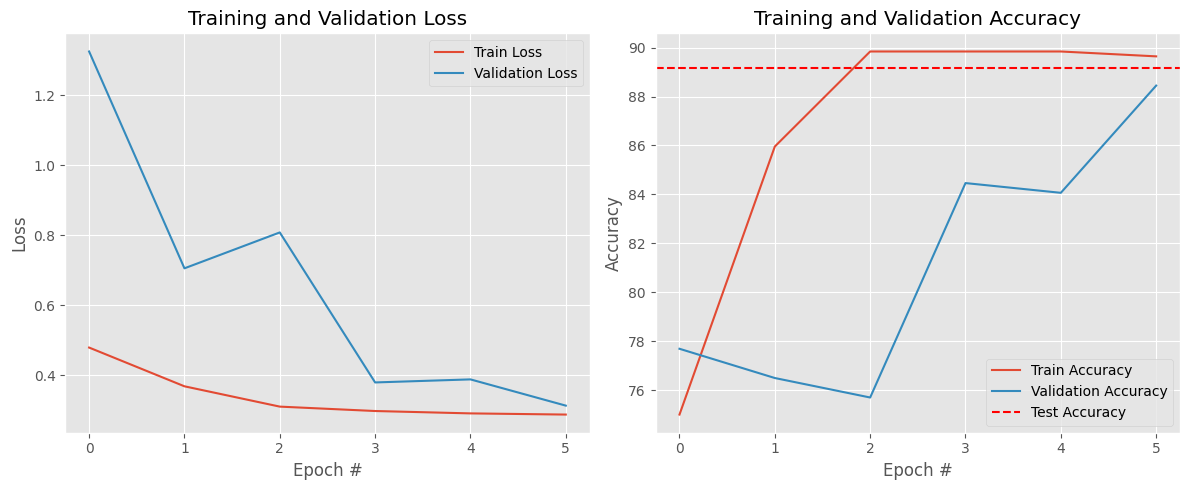

In [ ]:
# train final model
set_random_seed()
dropout_rate = study.best_params.get('dropout_rate')
learning_rate = study.best_params.get('learning_rate')
model = FC_CNN(dropout_rate)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')
train_model(model, criterion, optimizer, num_epochs, train_loader, val_loader,
            device, testloader = test_loader)

In [ ]:
# save model
torch.save(model, os.path.join(WORKING_PATH,OUTPUTDIR,NAMESTUDY + "_model.pth"))